In [218]:
import pandas as pd
import numpy as np
import dataset
import statsmodels as sts
import matplotlib.pyplot as plt
import seaborn as sns

In [219]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.0)
plt.rcParams['grid.linewidth'] = 0.5

# Loading & Describing the Dataset

In [220]:
augmented_cmu = dataset.get_augmented_cmu()
imdb_df = dataset.get_imdb_dataset()
boxofficemojo = dataset.get_boxofficemojo_dataset()
rottentomatoes = dataset.get_rottentomatoes_dataset()
awards_df = dataset.load_dataset('Output/awards.csv')

/Users/hanskristianbjorgokvaerum/EPFL/ADA/ada-2023-project-biasbusters/dataset.py:27: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_title_basics = pd.read_csv('Data/imdb/title.basics.tsv', sep='\t')


### Exploring Augmented CMU

#### Movies per Year

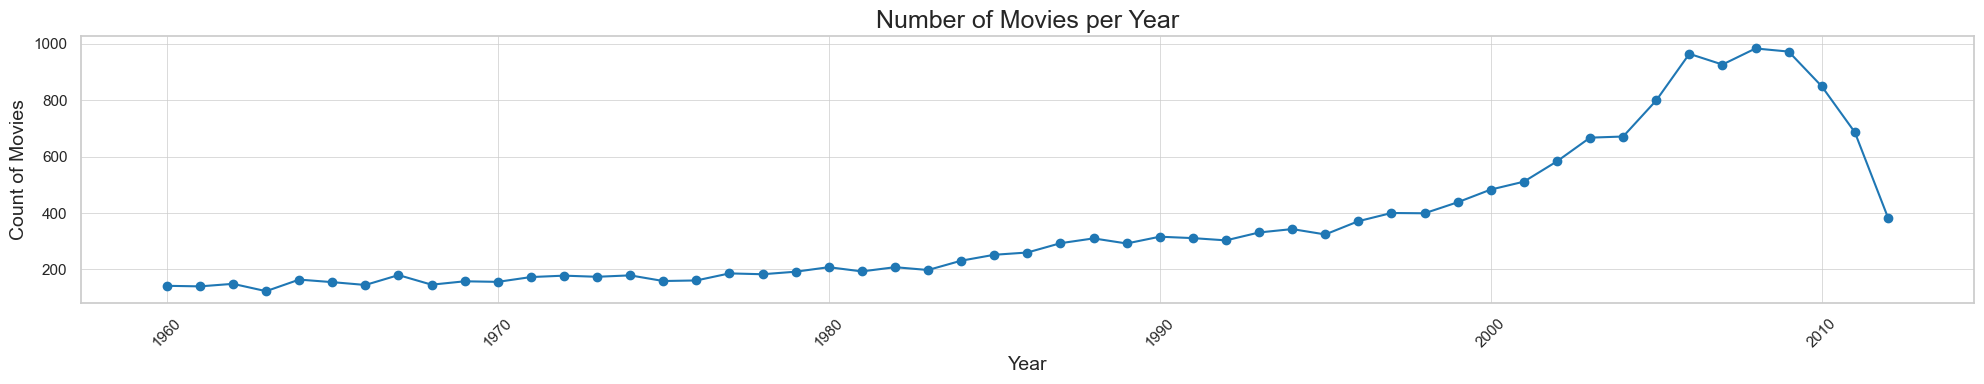

In [221]:
movies_per_year = augmented_cmu.groupby(by=['release_year']).size().reset_index(name='count').sort_values(by='release_year', ascending=True)

# Plotting
plt.figure(figsize=(20, 4))  # Set the figure size for better readability
plt.plot(movies_per_year['release_year'], movies_per_year['count'], marker='o', linestyle='-')

# Adding titles and labels, styling the plot
plt.title('Number of Movies per Year', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count of Movies', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.show()

**Comments:** after processing, we have approximately 200 movies++ for each year. Movies from 1960-2014 are present in the dataset.

#### Exploring Genre Associations

/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_86969/1326848714.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues', max(partition.values()) + 1)


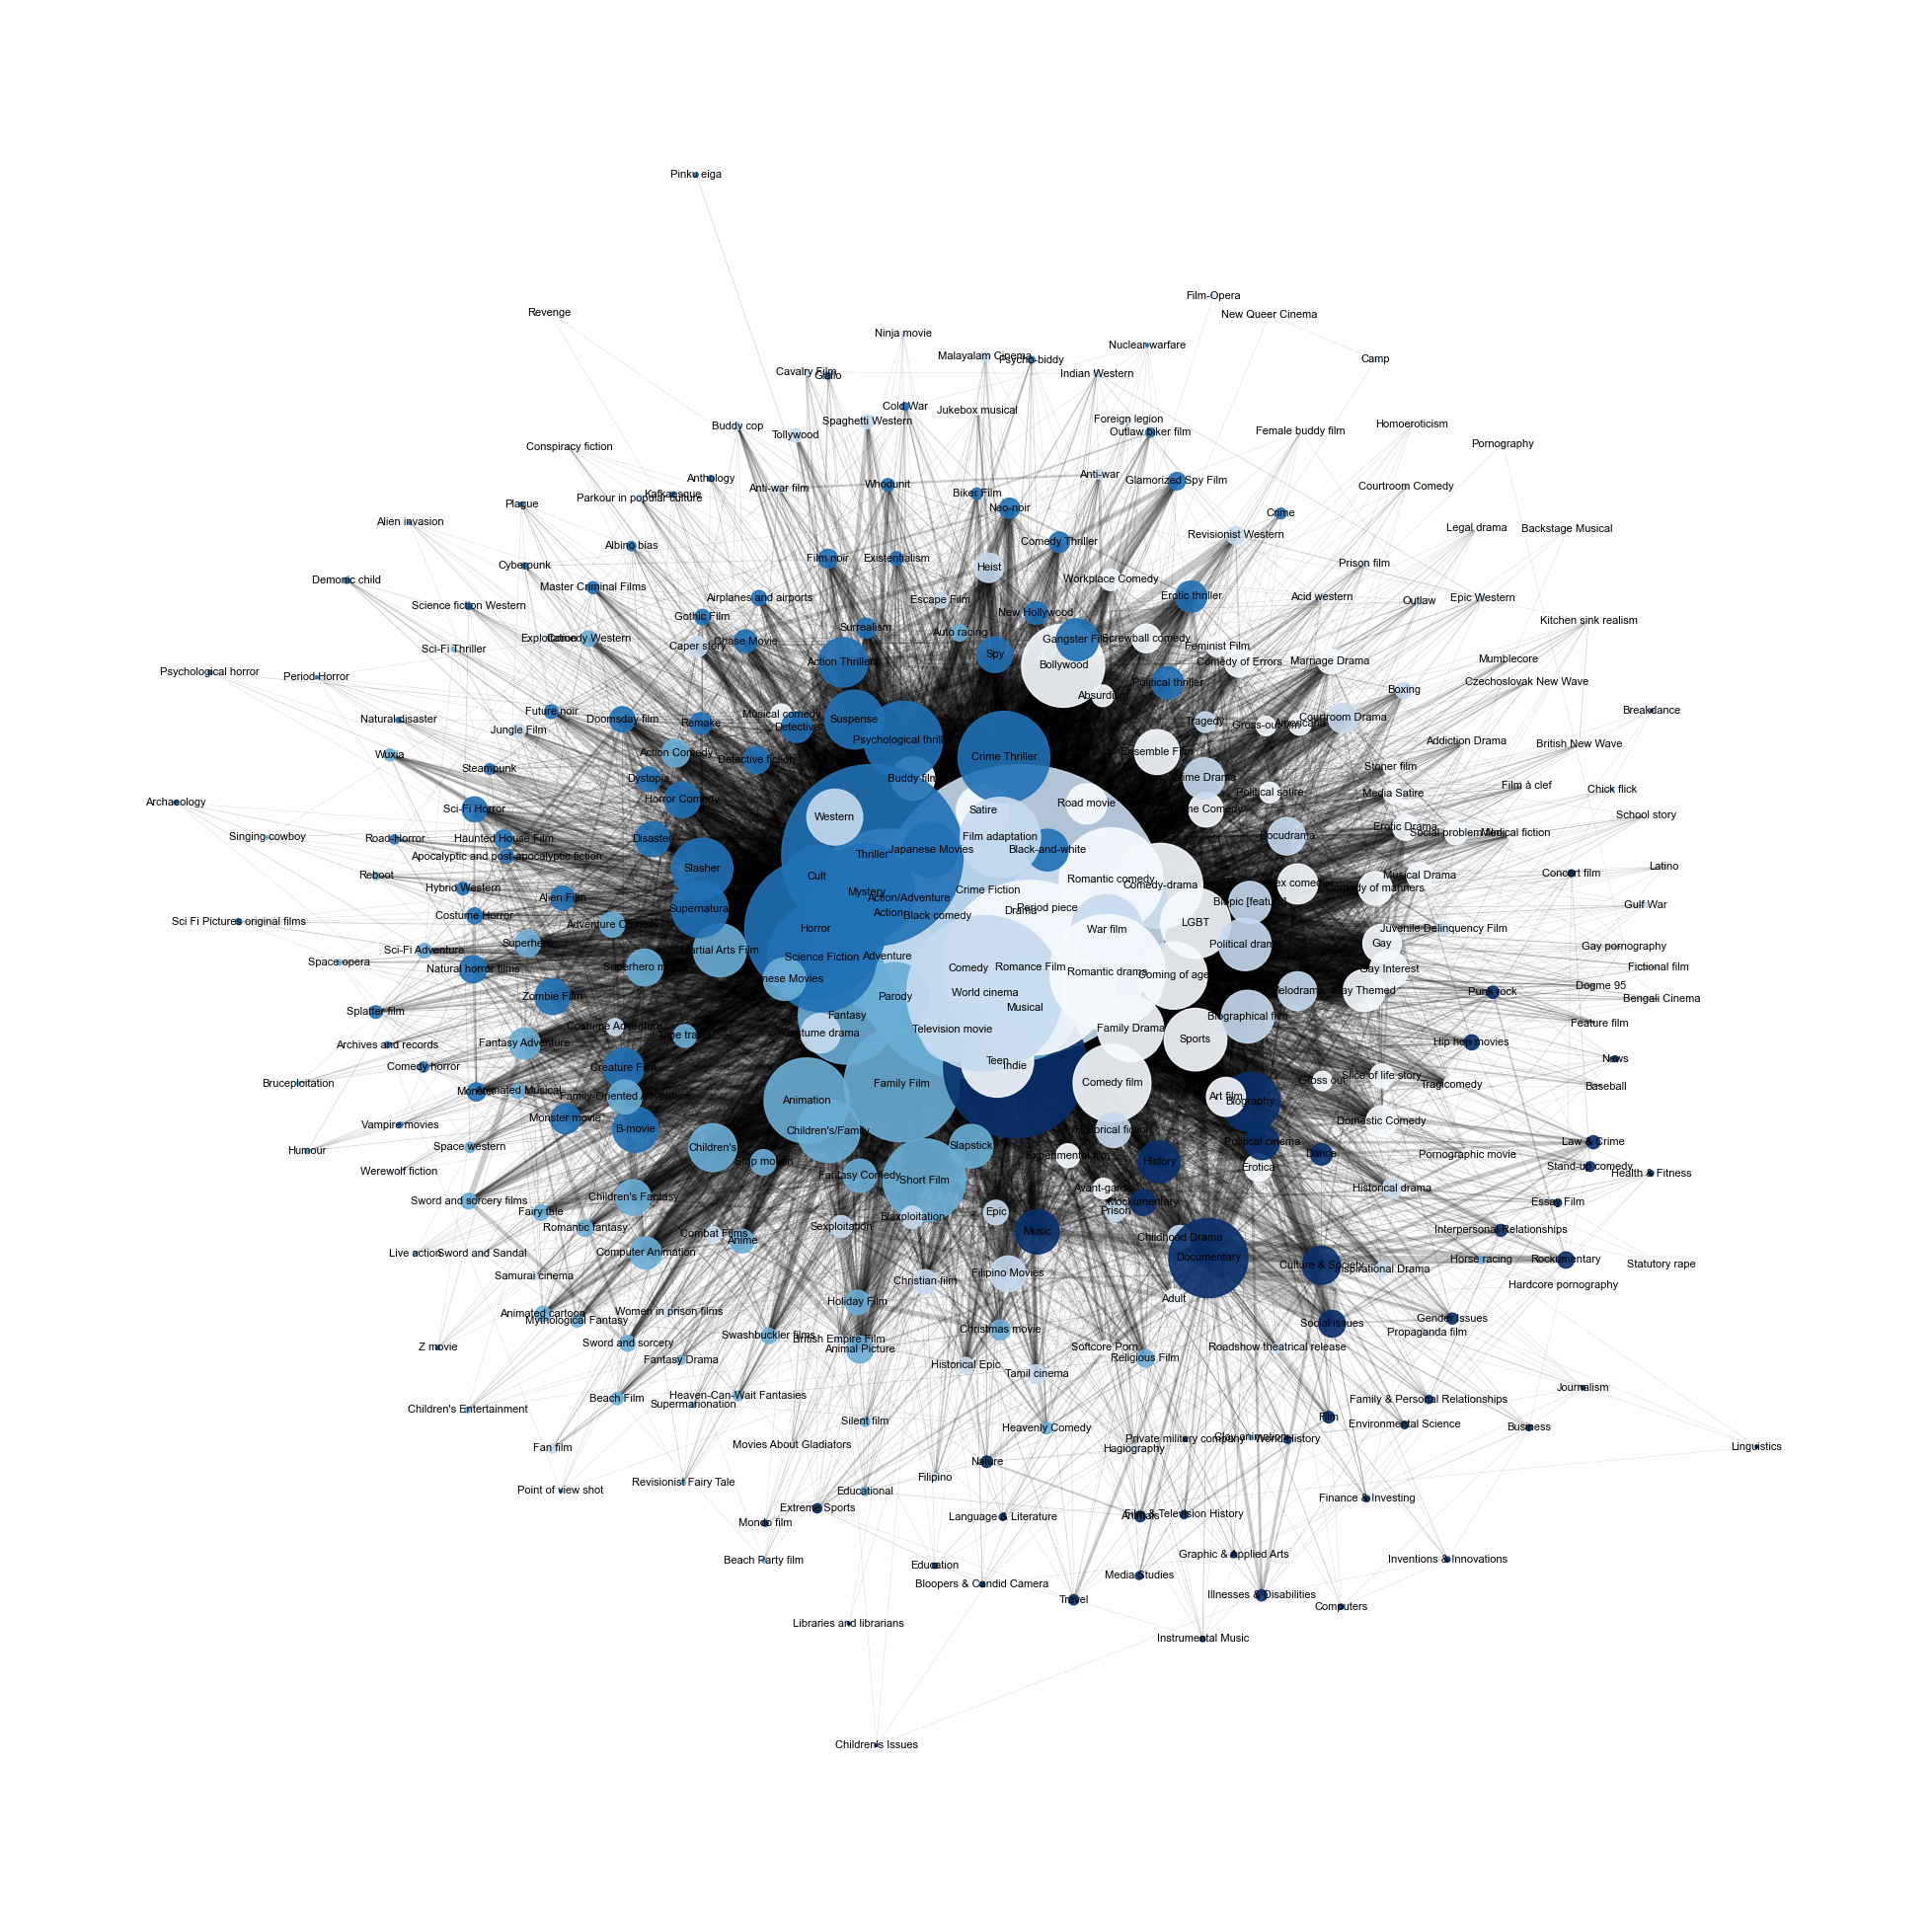

In [251]:
import itertools
import networkx as nx
import community as community_louvain
import matplotlib.cm as cm
import json

genres_list = augmented_cmu[~augmented_cmu['genres'].isna()]['genres'].apply(lambda x: list(json.loads(x).values())).tolist()

# Create a list of all pairs of genres that appear together
genre_pairs = list(itertools.chain(*[itertools.combinations(sorted(genres), 2) for genres in genres_list]))

# Create a DataFrame with each pair and count occurrences
genre_pair_df = pd.DataFrame(genre_pairs, columns=['Genre1', 'Genre2'])
genre_pair_count = genre_pair_df.groupby(['Genre1', 'Genre2']).size().reset_index(name='Count')

# Calculate the total number of movies for each genre
genre_movie_count = pd.Series(itertools.chain(*genres_list)).value_counts()

# Create a network graph
G = nx.from_pandas_edgelist(genre_pair_count, 'Genre1', 'Genre2', edge_attr='Count')

# Draw the network with varying node size and edge width
node_size = [genre_movie_count.get(genre, 0) * 5 for genre in G.nodes()]
edge_width = [1 + G[u][v]['Count'] * 0.1 for u, v in G.edges()]

# Generate the initial Kamada-Kawai layout positions
pos = nx.kamada_kawai_layout(G, dist=None, weight='weight', scale=1, center=None, dim=2)

# Detect communities & create a colormap
partition = community_louvain.best_partition(G)
community_colors = [partition.get(node) for node in G.nodes()]
cmap = cm.get_cmap('Blues', max(partition.values()) + 1)

# Adjust node positions to separate communities (optional post-processing step)
for node, community in partition.items():
    pos[node] += np.array([np.cos(community), np.sin(community)]) * 0.01

# Draw the network with reduced edge width and increased transparency
edge_width = [0.05 + G[u][v]['Count'] * 0.2 for u, v in G.edges()]  # Adjusted edge width calculation

plt.figure(figsize=(25, 25))
nx.draw_networkx_nodes(G, pos, node_size=node_size, cmap=cmap, node_color=community_colors, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

plt.axis('off')
plt.show()


**Comment:** The graph is made using NetworkX with kamada_kawai_layout for increased separability. Each node represent a movie genre, and an edge between two nodes signifies that at least one movie in the dataset is categorized under both genres. Node size is determined by the count of movies tagged with the genre, and the edge-weighting equals the amount of edges between two nodes. Louvain method is used for detecting communities, which are represented by the various colours. Even though the graph is quite cluttered, it gives an indication of:

1. **Genre commonality:** More prominent nodes suggest the most common genres within the dataset. However, one can clearly see that the smaller nodes in the outer regions of the network is much more specific (e.g Beach Party Film, Breakdance, Inventions & Innovations), probably indicating the specific topic(s) of a movie categorized under a broader genre.
2. **Genre affinity:** Genres that are closely connected and part of the same community likely share some thematic or stylistic elements that lead them to be frequently paired in movies.
3. **Isolated Communities:** Smaller clusters or individual nodes that are not densely connected to the main body of the graph could represent niche genres or less common genre combinations. The graph is too cluttered to identify such isolations visually.

Now, we should explore the communities and genres a bit more in depth.

#### Making Sense of the Network

In [252]:
# Generate an aggregated dataframe with genre-label count
genres_df = augmented_cmu.copy()[~augmented_cmu['genres'].isna()][['movie_name','genres']]
genres_df['genres'] = genres_df['genres'].apply(lambda x: list(json.loads(x).values()))
genres_df = genres_df.explode(column='genres').groupby('genres').size().reset_index(name='count').sort_values(by='count', ascending=False)

# Merge with community
community_df = pd.DataFrame(list(partition.items()), columns=['genres', 'community'])
genre_community = pd.merge(left=genres_df, right=community_df, how='inner', on='genres')

/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_86969/635013803.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues', max(community_movie_counts.index) + 1)


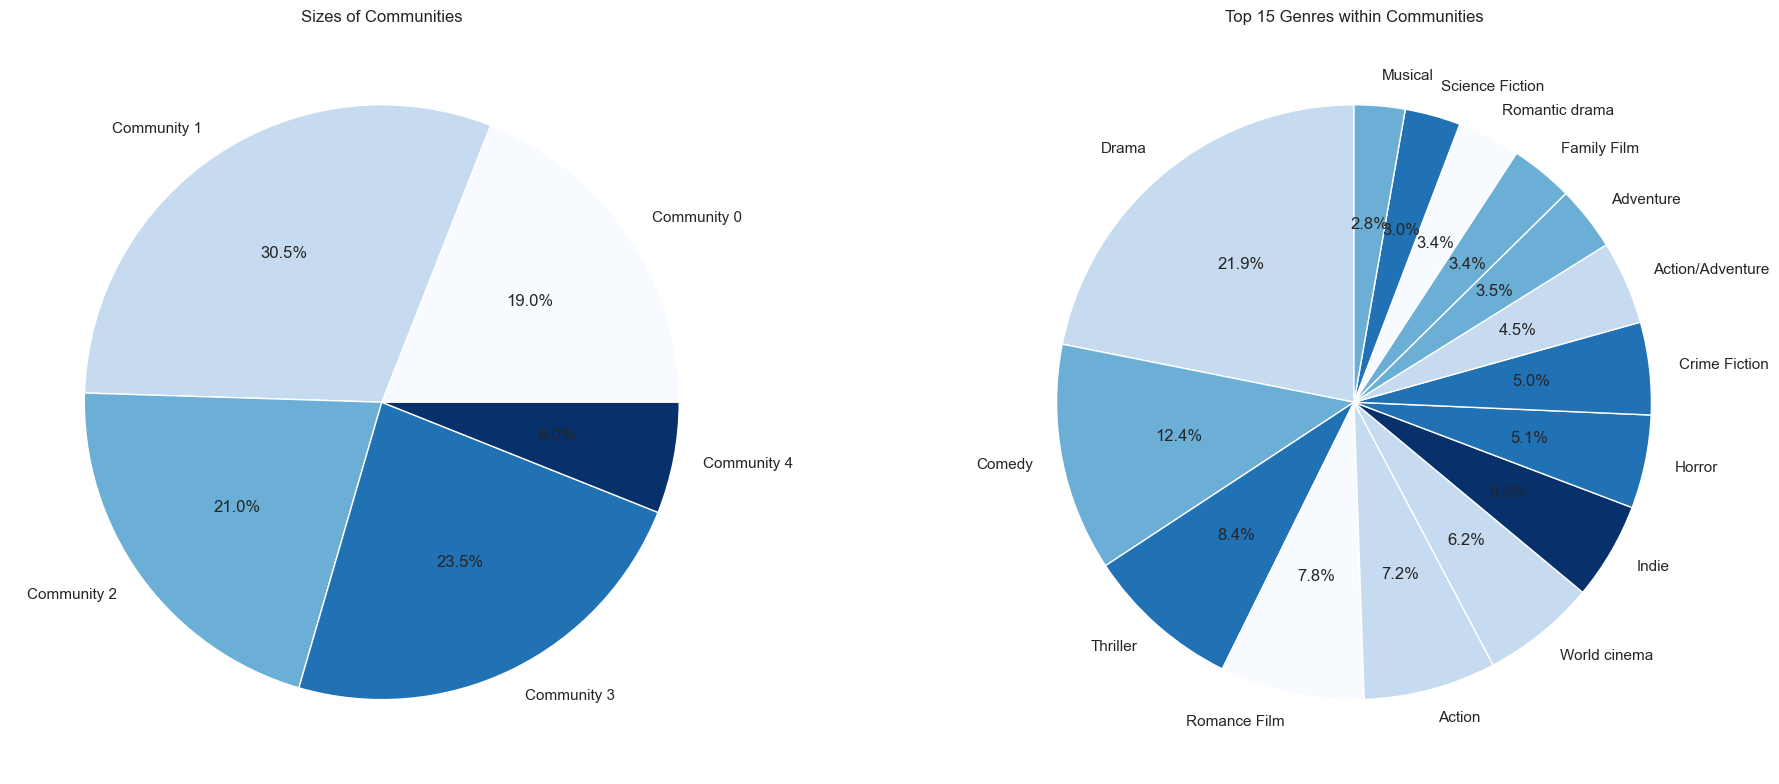

The top 15 genres represent 57.09% of the total count.


In [254]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba_array
import matplotlib.cm as cm
import community as community_louvain

# Assuming 'partition' and 'genre_community' are pre-defined
# and 'community_louvain.best_partition(G)' has been run to create 'partition'

# Aggregate the total movie count for each community
community_movie_counts = genre_community.groupby('community')['count'].sum()

# Create a color map for communities
cmap = cm.get_cmap('Blues', max(community_movie_counts.index) + 1)
community_colors = cmap(range(max(community_movie_counts.index) + 1))

# Define the number of top genres to display
top_n = 15

# Filter to the top N genres by count
top_genres = genre_community.nlargest(top_n, 'count')

# Create subplots for the pie charts
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Left pie chart - Community sizes
community_labels = [f'Community {comm}' for comm in community_movie_counts.index]
community_sizes = community_movie_counts.values
axs[0].pie(community_sizes, labels=community_labels, colors=community_colors, autopct='%1.1f%%')
axs[0].set_title('Sizes of Communities')

# Right pie chart - Genres colored by community
# Map genres to their community color
genre_community['color'] = genre_community['community'].apply(lambda x: to_rgba_array(community_colors[x]))
genre_labels = genre_community['genres']
genre_sizes = genre_community['count']
genre_colors = genre_community['color']
axs[1].pie(top_genres['count'], labels=top_genres['genres'], colors=top_genres['color'], autopct='%1.1f%%', startangle=90)
axs[1].set_title(f'Top {top_n} Genres within Communities')

# Show the plot
plt.tight_layout()
plt.show()


# Calculate the sum of counts for the top N genres
sum_top_n = top_genres['count'].sum()

# Calculate the sum of counts for all genres
total_sum = genre_community['count'].sum()

# Calculate the percentage of the total movie count represented by the top N genres
percentage_top_n = (sum_top_n / total_sum) * 100

# Print the statement
print(f"The top {top_n} genres represent {percentage_top_n:.2f}% of the total count.")



**Comment:** visualizing the communities like this gives a much better understanding of the clustering done with the Louvain method. As we can see, community 4, including genres Thriller, Action, Horror, Crime-Fiction and Science-fiction, is the largest community of the network (29.4%), while community 1, including genres like Romance Film, Romantic Drama, Musical, is the smallest community of the network (10.7%). It is worth mentioning that the right pie-chart only represent 57.09% of the total genre-label-count, where the top 15 genres where chosen for better readability. 

For later analysis, these communities will allow us to preserve the full dataset for our analysis instead of filtering on genre, which would potentially exclude niche movies with rare genre-labeling. AND: if we at some point want to go deeper, we can just drill down into the community! 

#### Interpreting the Communities

Now that we have seen the most prominent genres within each community, we can use topic modelling to better understand each community, allowing us to provide useful interpretations of them.

**Methodology:**
1. Community Aggregation: Create a "document" for each community by aggregating all the genres within that community.
2. Data Preparation: Convert the aggregated genre data into a format suitable for topic modeling (term-frequency matrix).
3. Topic Modelling Algorithm: Use Latent Dirchlet Allocation (LDA) for topic modelling
4. Interpretation/Visualization: Visualize and interpret the results to label/define the communities

In [255]:
from gensim.utils import simple_preprocess
from gensim import corpora, models
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
stop_words.extend(['film', 'movie', 'cinema'])

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hanskristianbjorgokvaerum/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hanskristianbjorgokvaerum/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [256]:
def generate_doc(genre_community, community):
    genres = genre_community[genre_community['community'] == community]['genres'].tolist()
    doc = ' '.join(genres).lower().replace('-', ' ')
    tokens = [word for word in simple_preprocess(doc) if word not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return lemmatized_tokens

# Create a doc for each community
community_docs = {community: generate_doc(genre_community, community) for community in set(genre_community['community'].unique())}

# Create a dictionary for each community
community_dictionaries = {community: corpora.Dictionary([doc]) for community, doc in community_docs.items()}

# Create a corpus for each community using the corresponding dictionary
community_corpora = {community: community_dictionaries[community].doc2bow(doc) for community, doc in community_docs.items()}

# Fit an LDA model for each community
community_lda_models = {}
for community in community_corpora:
    dictionary = community_dictionaries[community]
    corpus = [community_corpora[community]]
    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=1, passes=15)
    community_lda_models[community] = lda_model

# Now you can print the topic for each community
for community, lda_model in community_lda_models.items():
    print(f"Community {community} topic:")
    # Each community will have only one topic since num_topics=1
    for topic in lda_model.print_topics(num_words=10):
        print(topic)

Community 0 topic:
(0, '0.066*"comedy" + 0.050*"drama" + 0.028*"gay" + 0.022*"satire" + 0.022*"musical" + 0.017*"gross" + 0.017*"pornography" + 0.017*"buddy" + 0.017*"romantic" + 0.017*"wave"')
Community 1 topic:
(0, '0.044*"drama" + 0.034*"western" + 0.024*"war" + 0.020*"prison" + 0.020*"historical" + 0.020*"fiction" + 0.020*"epic" + 0.015*"filipino" + 0.015*"movie" + 0.015*"courtroom"')
Community 2 topic:
(0, '0.052*"fantasy" + 0.041*"comedy" + 0.035*"adventure" + 0.029*"child" + 0.023*"family" + 0.023*"animation" + 0.017*"space" + 0.017*"film" + 0.017*"action" + 0.017*"sorcery"')
Community 3 topic:
(0, '0.045*"horror" + 0.036*"thriller" + 0.027*"fiction" + 0.023*"comedy" + 0.018*"noir" + 0.018*"film" + 0.018*"crime" + 0.014*"psychological" + 0.014*"science" + 0.014*"detective"')
Community 4 topic:
(0, '0.027*"history" + 0.027*"issue" + 0.020*"relationship" + 0.020*"music" + 0.014*"mondo" + 0.014*"mockumentary" + 0.014*"military" + 0.014*"medium" + 0.014*"literature" + 0.014*"librari

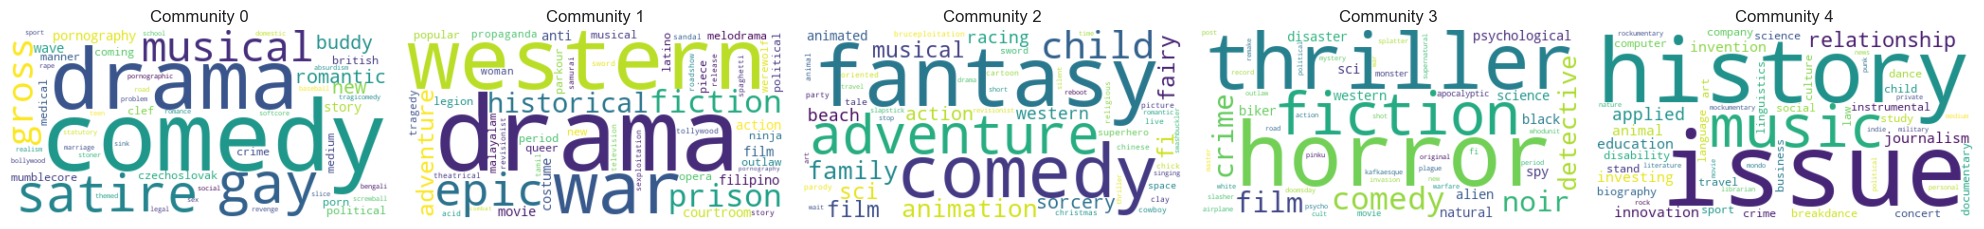

In [258]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming 'community_lda_models' is a dictionary with community numbers as keys
# and LDA model objects as values
# Define the subplot grid
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Adjust the size as needed

# Generate a word cloud for each community's topic and add it to the subplot
for i, (community, lda_model) in enumerate(community_lda_models.items()):
    # Extract the words and their probabilities
    topic_words = dict(lda_model.show_topic(0, topn=50))
    # Generate the word cloud
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(topic_words)
    
    # Plot the word cloud in the ith subplot
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(f'Community {community}')
    axs[i].axis('off')

# Adjust the layout
plt.tight_layout()
plt.show()


**Comment:** These are the word-cloud of the genre-names belonging to each community weighted equally.

### Labeling the Communities
The LDA model results offer insights into the dominant themes within each community. Let's interpret these results and suggest potential labels for each community:


| Community | Dominant Genres/Themes                        | Interpretation                                                                                                  | Suggested Label                     |
|-----------|------------------------------------------------|-----------------------------------------------------------------------------------------------------------------|-------------------------------------|
| 0         | Comedy, Drama, Musical, Gay, Satire            | Mix of light-hearted and serious themes with comedic and dramatic elements. Themes of LGBTQ+ and social commentary. | "Comedic Drama & Social Commentary" |
| 1         | Drama, Western, War, Historical, Epic          | Characterized by dramatic and historical themes in war and Western settings. Grand and complex narratives.      | "Epic Historical Drama"               |
| 2         | Fantasy, Comedy, Adventure, Children, Family   | Fantastical and adventurous themes suitable for a family audience, geared towards younger viewers.              | "Family-Friendly Fantasy & Adventure" |
| 3         | Horror, Thriller, Fiction, Comedy, Noir        | Blend of horror and thriller with comedy. Dark, suspenseful, and potentially speculative themes.                | "Dark & Suspenseful Fiction"          |
| 4         | History, Issues, World, Relationships, Music   | Focus on historical and global issues in the context of interpersonal relationships and music.                  | "Historical & Cultural Narratives"    |

As for the dominant genres/themes, 'Drama' and 'Comedy' are not exclusive characteristics. This prompts the question: how alike are the communities topic-wise?

In [319]:
community_labels = ['Comedic Drama & Social Commentary (C0)', 'Epic Historical Drama (C1)', 'Family-Friendly Fantasy & Adventure (C2)', 'Dark & Suspenseful Fiction (C3)', 'Historical & Cultural Narratives (C4)']

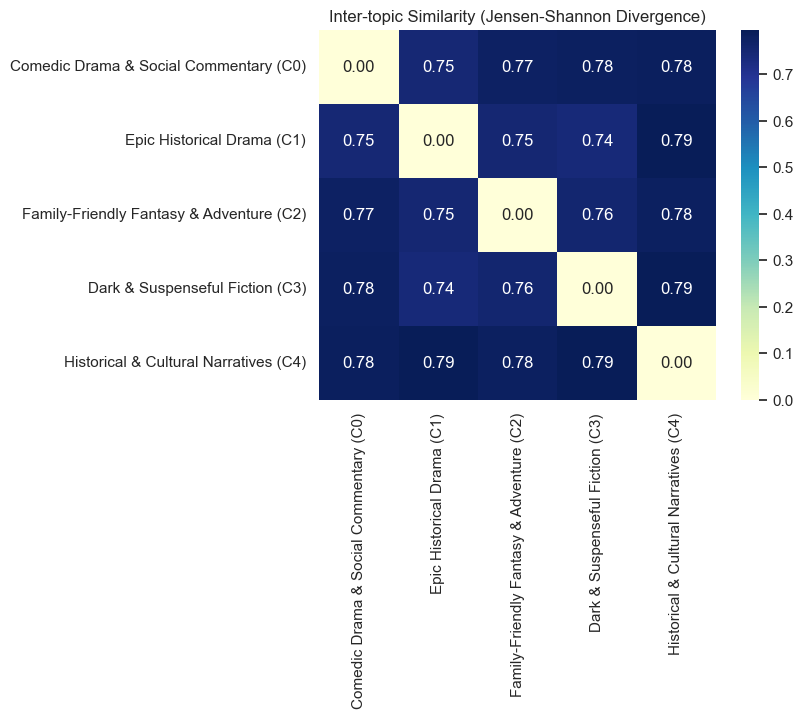

In [293]:
from scipy.spatial.distance import jensenshannon

# Assuming 'community_lda_models' is your dictionary of LDA models
num_communities = len(community_lda_models)
topic_distributions = np.zeros((num_communities, len(dictionary)))

# Extract all unique words from the LDA models
unique_words = set()
for lda_model in community_lda_models.values():
    unique_words.update(word for word, _ in lda_model.show_topic(0, topn=len(dictionary)))

# Create a new dictionary with these unique words
new_dictionary = corpora.Dictionary([list(unique_words)])

# Extract the topic distribution for each community
topic_distributions = np.zeros((num_communities, len(new_dictionary)))

for i, lda_model in enumerate(community_lda_models.values()):
    for word, weight in lda_model.show_topic(0, topn=len(new_dictionary)):
        if word in new_dictionary.token2id:
            topic_distributions[i, new_dictionary.token2id[word]] = weight

# Compute pairwise Jensen-Shannon divergence
js_distances = np.zeros((num_communities, num_communities))
for i in range(num_communities):
    for j in range(num_communities):
        js_distances[i, j] = jensenshannon(topic_distributions[i], topic_distributions[j])

# Create a heatmap
sns.heatmap(js_distances, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=community_labels, yticklabels=community_labels)
plt.title('Inter-topic Similarity (Jensen-Shannon Divergence)')
plt.show()


**Comment:** The Jensen-Shannon divergence measures the similarity between two probability distributions, and is useful in topic modelling to compare the distribution of topics in different documents/sets of documents. The divergence score ranges from 0 to 1, where 0 indicates identical distributions and 1 indicates completely different distributions. From the heatmap, we observe that none of the communities have a divergence of 0, meaning that there's no pair of (different) communities with identical topic distributions. As all of the scores are releatively high (0.74 to 0.79), we can conclude that while there are some overlaps, each community is relatively distinct in terms of the topics it covers.

### Assigning Movies to Communities

Until now, we've only looked at the genre-communities, but we're interested in movies! Therefore, we need to assign movies to communities based on their genre-labeling. Because a movie can be associated with multiple genres, of which can be associated with different communities, we start by computing the probability of a movie belonging to each community.

In [311]:
movie_genres= augmented_cmu.copy()[~augmented_cmu['genres'].isna()][['movie_wikipedia_id','genres']]
movie_genres['genres'] = movie_genres['genres'].apply(lambda x: list(json.loads(x).values()))

# Convert dataframe to dictonary for instant lookup instead of query
genre_to_community_dict = pd.Series(genre_community['community'].values, index=genre_community['genres']).to_dict()

# @Function compute probabilities for soft assignment
def community_soft_assignment(genre_to_community_dict, genres_list, movie_wikipedia_id):
    # Initialize counters for genre occurrences in communities
    community_counters = {community: 0 for community in set(genre_to_community_dict.values())}
    
    # Count the number of genres that map to each community
    for genre in genres_list:
        community = genre_to_community_dict.get(genre)
        if community is not None:
            community_counters[community] += 1
    
    # Total number of genres for the movie
    total_genres = len(genres_list)
    
    # Calculate probabilities for each community
    if total_genres > 0:  # Ensure we don't divide by zero
        prob_dict = {f'prob_c{community}': count / total_genres for community, count in community_counters.items()}
    else:
        prob_dict = {f'prob_c{community}': 0 for community in community_counters.keys()}
    
    prob_dict['movie_wikipedia_id'] = movie_wikipedia_id
    
    return prob_dict


records = movie_genres.to_dict(orient='records')
results = []

for record in records:
    tmp = community_soft_assignment(genre_to_community_dict, record['genres'], record['movie_wikipedia_id'])
    results.append(tmp)

movie_community = pd.DataFrame(results)


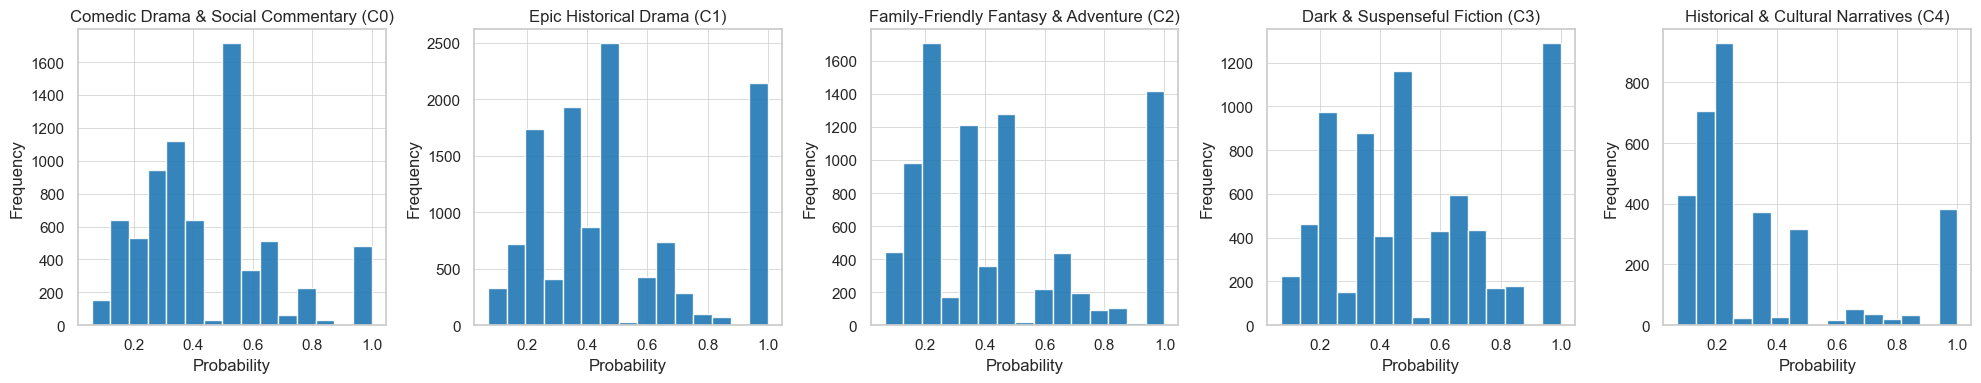

In [312]:
import matplotlib.pyplot as plt

# Define the subplot grid
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Adjust the size as needed

# Generate a histogram for each community's probability distribution
for i in range(5):
    community_prob_column = f'prob_c{i}'
    axs[i].hist(movie_community[movie_community[community_prob_column] != 0.0][community_prob_column], bins=15, alpha=0.9)
    axs[i].set_title(community_labels[i])
    axs[i].set_xlabel('Probability')
    axs[i].set_ylabel('Frequency')

# Adjust the layout
plt.tight_layout()
plt.show()


In [316]:
def hard_assignment(row):
    # Exclude the movie name from the probabilities
    probabilities = {k: v for k, v in row.items() if 'prob_c' in k}
    # Get the key with the max probability
    max_prob_key = max(probabilities, key=probabilities.get)
    # Extract the cluster number from the key, removing the 'c' before casting to int
    cluster = int(max_prob_key[-1])
    return cluster

# Apply the function to each row (axis=1 specifies row-wise operation)
movie_community['hard_assignment'] = movie_community.apply(hard_assignment, axis=1)


**Comment:** This gives gives much more nuanced information than our initial plot! 

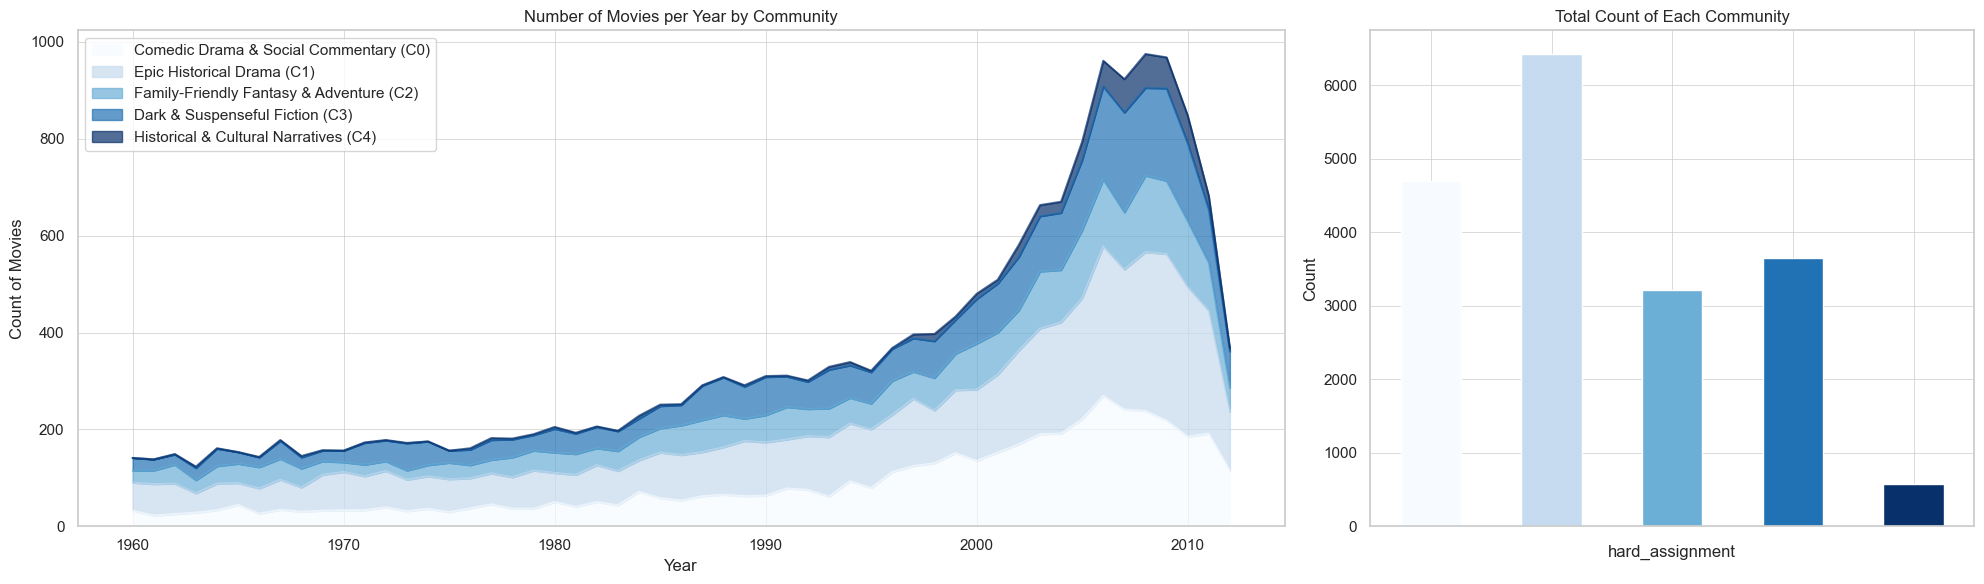

In [371]:
import matplotlib.pyplot as plt

# Assume movies_per_year_community is your dataframe for the stacked line chart
# Assume community_counts is a Series or list with the count of each community

# Define the subplot grid layout
fig, axs = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'width_ratios': [2, 1]})

# Stacked line chart spanning the first two columns
movies_per_year_community.plot(kind='area', stacked=True, 
                               color=[community_colors[i][0] for i in movies_per_year_community.columns], 
                               alpha=0.7, ax=axs[0])

axs[0].set_title('Number of Movies per Year by Community')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Count of Movies')
axs[0].legend(loc='upper left')


community_counts = movies_per_year_community.sum()
# Barchart in the third column
community_counts.plot(kind='bar', 
                      color=[community_colors[i][0] for i in movies_per_year_community.columns], 
                      alpha=1, ax=axs[1], )

axs[1].set_title('Total Count of Each Community')
axs[1].set_ylabel('Count')
axs[1].set_xticklabels([])

# Adjust the layout to prevent overlapping content
plt.tight_layout()
plt.show()
